# Simulation of Data Generation Process

**The task**: 

>Generate four “populations” of data: normal, lightly skewed, medium-skewed, heavily-skewed. This is your dependent variable (DV). Using dependent variables (DV), generate independent variables (IV) that correlate with each DV at 0%, 10%, 30%, 50%, and 70% (so you’ll end up with 20 “populations” of IVs).

The notation:

* $i$ - the case number, $j$ - the number of independent variable,
* The independent variables are $X_{ij}, i = 1..4, j = 1..5$,
* The dependent variables are $Y_i, i = 1..4$,

I use the [skewed normal distribution](https://en.wikipedia.org/wiki/Skew_normal_distribution) (with the skewness parameter $\alpha$) to generate the samples, each sample of the size n = 10000. The skewness parameter is set as follows

* $\alpha = 0$ for the normal distribution,
* $\alpha = 2$ for the lighty skewed normal distribution,
* $\alpha = 5$ for medium-skewed normal distribution,
* $\alpha = 25$ for heavily-skewed normal distribution.

For each of dependent random variables I generate the other five samples (at the required levels of correlation) by using the Cholesky transformation.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Loading required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#from scipy.stats import skewnorm
from sklearn.neighbors.kde import KernelDensity
import statsmodels.api as sm

plt.style.use('seaborn')

Setting some global and initial parameters

In [3]:
# the sample size (per case)
total_sample_size = 1000

# number of cases
cases_no = 4

# parameters of distributions
#   skewed_0 - normal, 
#   skewed_{i} - skewed (the more skewed the greater the index is)
norm_dist_params = {'xi': scipy.stats.skewnorm(loc = 0, scale = 1, a = 0),
                    'y0': scipy.stats.skewnorm(loc = 0, scale = 1, a = 0),
                    'y1': scipy.stats.skewnorm(loc = 0, scale = 1, a = 2),
                    'y2': scipy.stats.skewnorm(loc = 0, scale = 1, a = 5),
                    'y3': scipy.stats.skewnorm(loc = 0, scale = 1, a = 25)}

# the correlation matrix: y, x1, x2, ..., x5
corr_matrix = np.matrix([[1.0, 0.0, 0.1, 0.3, 0.5, 0.7],
                         [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                         [0.1, 0.0, 1.0, 0.0, 0.0, 0.0],
                         [0.3, 0.0, 0.0, 1.0, 0.0, 0.0],
                         [0.5, 0.0, 0.0, 0.0, 1.0, 0.0],
                         [0.7, 0.0, 0.0, 0.0, 0.0, 1.0]])

Drawing samples for both the dependent and independent variables

In [4]:
# generate samples with the Cholesky transformation
# this procedure generate all variables at once

# seed the random number generator
np.random.seed(42)

# draw random values out of those distributions
y = []
x = []
x_ = []

for i in range(cases_no):
    
    # build set of random variables
    rv_y = norm_dist_params['y%d' % i]
    #rv_x = norm_dist_params['xi']
    rv_x = rv_y
    
    rvs = np.matrix([rv_y.rvs(size = total_sample_size),
                     rv_x.rvs(size = total_sample_size),
                     rv_x.rvs(size = total_sample_size),
                     rv_x.rvs(size = total_sample_size),
                     rv_x.rvs(size = total_sample_size),
                     rv_x.rvs(size = total_sample_size)])
    
    # the transformation to align RV's at the required level of correlation
    c = np.linalg.cholesky(corr_matrix)
    rvs = c * rvs
    
    y.append(rvs[0].A[0])
    x.append(rvs[1:].T.A)
    x_.append(rvs[1:].A)
    
print('Y  shape: ' + str(np.shape(y)))
print('X  shape: ' + str(np.shape(x)))
print('X_ shape: ' + str(np.shape(x_)))

Y  shape: (4, 1000)
X  shape: (4, 1000, 5)
X_ shape: (4, 5, 1000)


In [5]:
df_sets = []

for i in range(cases_no):
    df_sets.append(pd.DataFrame({'y': y[i], 'x1': x[i][:,0], 'x2': x[i][:,1], 'x3': x[i][:,2], 'x4': x[i][:,3], 'x5': x[i][:,4]}))
    print(df_sets[i].head(2))

         x1        x2        x3        x4        x5         y
0  1.907808  0.561571 -0.341615  0.152690  2.059212  1.399355
1  0.860385  0.358678  1.403891 -1.679819 -0.798187 -0.924634
         x1        x2        x3        x4        x5         y
0  0.264708  0.736927  0.685183  1.650664  0.062306  1.056034
1  0.203180  0.260501  1.292616  0.780506  0.670007  1.444734
         x1        x2        x3        x4        x5         y
0  0.292306  1.901175  2.230189  0.393260  0.680649  0.624825
1  0.931270  0.841747  1.000947  1.399702 -0.486547  0.697534
         x1        x2        x3        x4        x5         y
0  0.414487  0.543702  0.608677  0.712201  0.152542  0.518464
1  1.064977  1.031913  0.792919  1.046035 -0.690098  0.144046


Checking the correlation between $Y_i$ and $X_{ij}$.

In [6]:
for i in range(cases_no):
    
    print('#%d      ' % i, end = '')
    for j in range(5):
        print('X%d      ' % j, end = '')
    print('')    
    
    print('Y%d   ' % i, end = '')
    for j in range(5):
        print('%+0.2f   ' % (round(np.corrcoef(y[i], x[i][:, j])[0][1],2)), end = '')
    print('')
    print('')

#0      X0      X1      X2      X3      X4      
Y0   +0.01   +0.08   +0.29   +0.50   +0.69   

#1      X0      X1      X2      X3      X4      
Y1   +0.02   +0.12   +0.24   +0.48   +0.71   

#2      X0      X1      X2      X3      X4      
Y2   +0.02   +0.10   +0.26   +0.49   +0.70   

#3      X0      X1      X2      X3      X4      
Y3   -0.06   +0.16   +0.29   +0.51   +0.70   



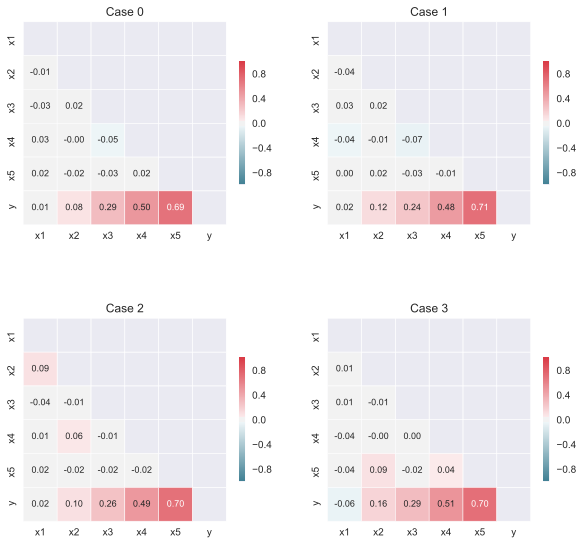

In [7]:
# plot correlation matrix
fig, axs = plt.subplots(figsize=(10, 10), nrows = 2, ncols = 2)

axs_flatten = axs.flatten()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

for i in range(cases_no):
    
    corr = df_sets[i].corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, 
                annot = True, annot_kws={"size": 9}, fmt = '.2f',
                cmap=cmap, vmin = -1, vmax= 1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = axs_flatten[i])
    axs_flatten[i].set_title('Case %d' % i)
 

plt.show()

True distribution of dependent variables

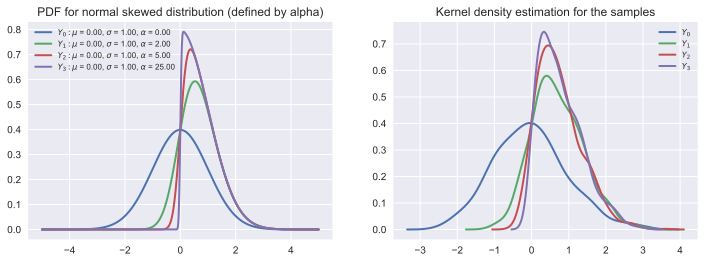

In [8]:
fig, axs = plt.subplots(figsize = (12, 4), ncols=2)

################################################################################
# draw ideal PDF of those DV's
################################################################################

plt.sca(axs[0])

x_range = np.linspace(-5, 5, total_sample_size)

for i in range(cases_no):
    # define a random variables with given parameters
    rv = norm_dist_params['y%d' % i]
    plt.plot(x_range, rv.pdf(x_range), lw = 2,
             label = r'$Y_%d: \mu$ = %1.2f, $\sigma$ = %1.2f, $\alpha$ = %1.2f' % 
             (i, rv.kwds['loc'], rv.kwds['scale'], rv.kwds['a']))

plt.title('PDF for normal skewed distribution (defined by alpha)')
plt.legend(fontsize = 8)

################################################################################
# draw kernel distribuion estimation of the samples
################################################################################

plt.sca(axs[1])

for i in range(cases_no):
    kde = sm.nonparametric.KDEUnivariate(y[i])
    # kde.fit(kernel = 'epa', fft = False)
    kde.fit() # gaussian kernel with fft
    plt.plot(kde.support, kde.density, lw = 2, label='$Y_%d$' % i)

plt.title('Kernel density estimation for the samples')
plt.legend(fontsize = 8)

plt.show()

Now, there are four sets of samples, one set per each required combination of DV and IVs in the variables y and x. Let's do some simulation with it.

# Simulation (Linear Regression of Samples)

**The task:**

>Your simulations should do the following:
>1.	Create a linear regression model with one DV and 5 IVs (such that x1 correlates 10% with DV, x2 – 30%, etc.)
>2.	Generate 1000 (or more, if you wish) samples each of size 15, 30, 50, 100 for normal and skewed DVs
>3.	For each sample, run a linear regression and record R2, F-value, and p-values of each IV 
>4.	Analyze the results. Does non-normality have an impact on Type I and Type II error rates?



We understand the task is that we need to run the simulation for 1-4 for each set of DV and IVs (we have four of them, let's call them cases). Variability among runs of the experiment is defined by randomness of samples and their size.

Creating linear regression models, the models are stored in the *models* list

In [9]:
import statsmodels.api as sm

models = []
fits   = []

for i in range(cases_no):
    models.append(sm.OLS(y[i], sm.add_constant(x[i])))
    fits.append(models[i].fit())
    
print(fits[0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1035.
Date:                Thu, 21 Jun 2018   Prob (F-statistic):               0.00
Time:                        14:42:03   Log-Likelihood:                -505.10
No. Observations:                1000   AIC:                             1022.
Df Residuals:                     994   BIC:                             1052.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0050      0.013     -0.390      0.6

Creating major structures to work with those small but numerous samples

In [10]:
# number of iterations
iter_no = 1000

# sizes of samples
sample_sizes = (15, 30, 50, 100)

# samples in the following structure 
# {'case id': 
#     {'15':  <list of small samples>,
#      '30':  <list of small samples>,
#      '50':  <list of small samples>,
#      '100': <list of small samples>}}

samples = {}

# sample OLS fits
samples_fits = {}

Preparing those small samples

In [11]:
np.random.seed(42)

for case in range(cases_no):
    samples[case] = {}
    for sample_size in sample_sizes:
        samples[case][sample_size] = []
        for j in range(iter_no):
            # randomly generating indexes for those observations we'll take for the current sample
            indexes = np.random.randint(0, total_sample_size - 1, sample_size)
            ys = np.take(y[case], indexes)
            xs = np.take(x[case], indexes, axis = 0)
            samples[case][sample_size].append([ys, xs])

Checking what a small sample looks like. It should be a list of two arrays: Y - the first one (1D), X - the second one (2D).

In [12]:
print('Y')
print()
print(samples[0][15][0][0])
print()
print('X1 - X5')
print()
print(samples[0][15][0][1])

Y

[-2.0883747   0.28257995 -0.13430874  1.09131012  0.61277391  0.47704083
 -0.3506301   0.52283549 -0.18047991 -1.18703031  1.6699045   0.29494968
 -1.53075083 -1.28975275  0.23878916]

X1 - X5

[[-1.64948089  0.03824293 -0.73186837 -1.66343732 -0.64180631]
 [-0.88903712 -0.58165266 -0.17701362 -0.98785839  0.35658273]
 [ 0.45194937 -1.25060402 -1.96139951  0.83625685 -0.03562221]
 [-0.21566764 -1.1751574   2.004047   -0.93342949  0.22911838]
 [ 1.29314154  1.08608686 -1.69213856 -0.08289553  1.3932689 ]
 [ 1.70251466  0.26627243  1.02968818 -0.36383586  1.15146483]
 [ 1.06517197 -0.00969667  0.74440032 -0.52737835 -0.63261845]
 [ 1.20026175 -0.00533393  2.11196331 -0.22153899  0.2757695 ]
 [ 0.69285576 -0.5264758   1.39628328  0.07900752 -0.81345464]
 [-0.61216692  0.31526615 -1.17155031  0.72694923 -1.35232043]
 [ 0.41182337  0.45905661  0.80012968  1.98722093  0.58198811]
 [-0.735622    0.38808187  0.06426542  0.6561819  -0.34958458]
 [-0.91377162 -0.68913535  2.36310549 -2.404840

Fitting the models to those small samples. The results are gettings into the *fits* variable. It has the same structure as *samples*.

In [13]:
for case in range(cases_no):
    samples_fits[case] = {}
    for sample_size in sample_sizes:
        samples_fits[case][sample_size] = []
        for sample in samples[case][sample_size]:
            ys = sample[0]
            xs = sample[1]
            m = sm.OLS(ys, sm.add_constant(xs)).fit()
            samples_fits[case][sample_size].append(m)
            
#print(m1.rsquared)
#print(m1.fvalue)
#print(m1.pvalues)            

# Analysis

Let's build the distribution of each statistic for the linear regression models per each case and sample size

In [14]:
stats = {}

# stats in the following structure 
# {<case id>: 
#     {<sample size>: 
#         {'rsquared': list,
#          'fvalue':   list,
#          'pvalues':  list}}}

for case in range(cases_no):
    stats[case] = {}
    for sample_size in sample_sizes:
        stats[case][sample_size] = {}
        stats[case][sample_size]['rsquared'] = [sample.rsquared for sample in samples_fits[case][sample_size]]
        stats[case][sample_size]['fvalue']   = [sample.fvalue   for sample in samples_fits[case][sample_size]]
        stats[case][sample_size]['pvalues']  = [sample.pvalues  for sample in samples_fits[case][sample_size]]

In [15]:
samples_fits[0][15][0].pvalues[0]

0.745647466356172

## R^2

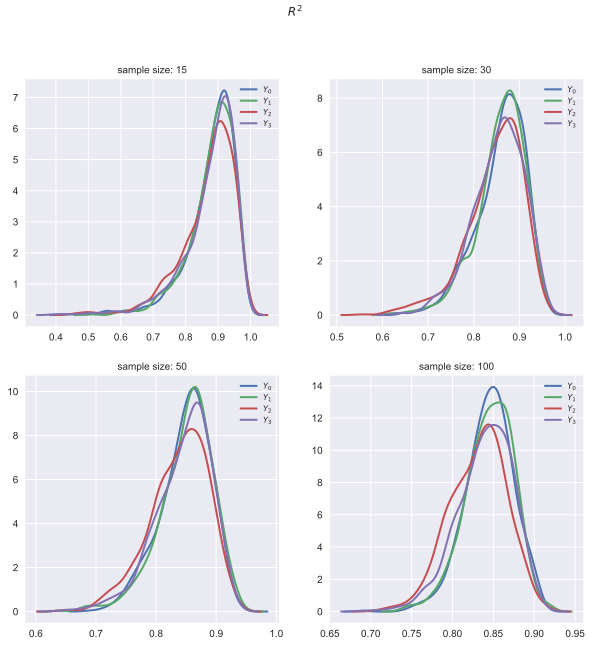

In [16]:
fig, axs = plt.subplots(figsize = (10, 10), nrows = 2, ncols=2)

axs_flatten = axs.flatten()

################################################################################
# draw ideal PDF of those DV's
################################################################################

for i in range(len(sample_sizes)):
    sample_size = sample_sizes[i]
    plt.sca(axs_flatten[i])
    for case in range(cases_no):
        kde = sm.nonparametric.KDEUnivariate(stats[case][sample_size]['rsquared'])
        # kde.fit(kernel = 'epa', fft = False)
        kde.fit() # gaussian kernel with fft
        plt.plot(kde.support, kde.density, lw = 2, label='$Y_%d$' % case)
        plt.legend(fontsize = 8)
        plt.title('sample size: %d' % sample_size, size = 10)

plt.suptitle('$R^2$')        
        
plt.show()

## F

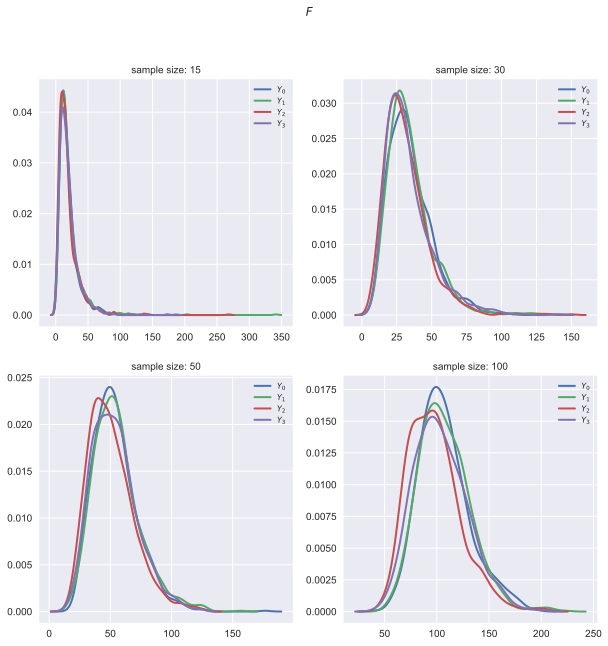

In [17]:
fig, axs = plt.subplots(figsize = (10, 10), nrows = 2, ncols=2)

axs_flatten = axs.flatten()

################################################################################
# draw ideal PDF of those DV's
################################################################################

for i in range(len(sample_sizes)):
    sample_size = sample_sizes[i]
    plt.sca(axs_flatten[i])
    for case in range(cases_no):
        kde = sm.nonparametric.KDEUnivariate(stats[case][sample_size]['fvalue'])
        # kde.fit(kernel = 'epa', fft = False)
        kde.fit() # gaussian kernel with fft
        plt.plot(kde.support, kde.density, lw = 2, label='$Y_%d$' % case)
        plt.legend(fontsize = 8)
        plt.title('sample size: %d' % sample_size, size = 10)

plt.suptitle('$F$')        
        
plt.show()

## p-values

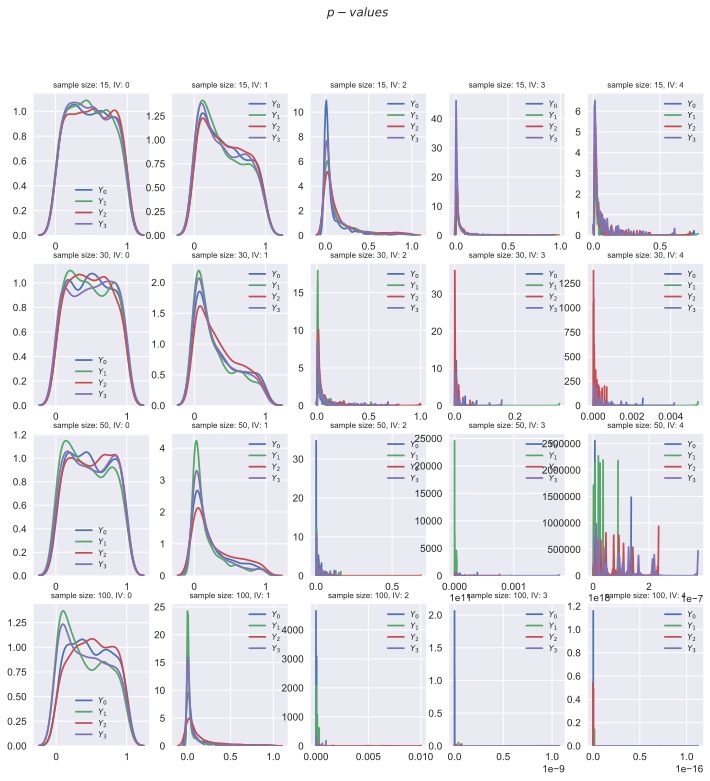

In [18]:
fig, axs = plt.subplots(figsize = (12, 12), nrows = 4, ncols=5)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axs_flatten = axs.flatten()

################################################################################
# draw ideal PDF of those DV's
################################################################################

for i in range(len(sample_sizes)):
    sample_size = sample_sizes[i]    
    for j in range(5):
        plt.sca(axs[i][j])
        for case in range(cases_no):
            # getting p-values for the case, this sample size, this variable
            p = [pvalues[j+1] for pvalues in stats[case][sample_size]['pvalues']]
            
            #kde = sm.nonparametric.KDEUnivariate(p)
            #kde.fit() # gaussian kernel with fft
            #plt.plot(kde.support, kde.density, lw = 2, label='$Y_%d$' % case)
            
            sns.distplot(p, hist = False, label='$Y_%d$' % case)
            
            plt.legend(fontsize = 8)
            plt.title('sample size: %d, IV: %d' % (sample_size, j), size = 8)

plt.suptitle('$p-values$')
        
plt.show()

# References

On the Cholesky transformation

1. http://code.activestate.com/recipes/576512-generating-correlated-random-numbers/
2. https://www.quantumforest.com/2011/10/simulating-data-following-a-given-covariance-structure/
3. https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution
4. https://blogs.sas.com/content/iml/2012/02/08/use-the-cholesky-transformation-to-correlate-and-uncorrelate-variables.html
5. https://math.stackexchange.com/questions/163470/generating-correlated-random-numbers-why-does-cholesky-decomposition-work

Other

5. http://www.statsmodels.org/dev/examples/notebooks/generated/kernel_density.html

# Appendix A The Cholesky Transformation

Ref.: http://code.activestate.com/recipes/576512-generating-correlated-random-numbers/

For two corelated variables, the formula is much as one would get from intuition about the meaning of correlation with some twist due to normalizing the standard deviation: $X_3 = \alpha X_1 + \sqrt{1-\alpha^2} X_2$ Where $X_1$ and $X_2$ are two independent random variables, and $\alpha$ is the coefficient of correlation between $X_1$ and $X_3$.

In a more general sense: 
Let $C$ be the correlation matrix desired. Let $X_1, X_2..., X_N$ be $N$ independent random variables arranged in a row matrix $R = [X_1, X_2,....,X_N]$. Then $Q = RU$ where $U^TU = C$ gives us $N$ random variables $Q = [Y_1, Y_2, ..., Y_N]$ with the required property.